# Image Generation Flow - Faceswap 

In [7]:
from random import choice
from string import digits
import warnings
warnings.filterwarnings("ignore")

import imageio
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
%matplotlib inline

from IPython.display import HTML

import torch
import torch.nn.functional as F
import cv2
import face_recognition

from part_swap import load_checkpoints, face_swap

## Paso 0: Cargar imagenes

In [8]:
source_path = '../resources/person.jpeg'
target_path = '../resources/sanchez_iglesias.jpg'
similarity_threshold = 0.7

In [9]:
source_image = imageio.imread(source_path)
source_image = resize(source_image, (256, 256)).astype('float32')[..., :3]

target_image = imageio.imread(target_path)
target_image = resize(target_image, target_image.shape[:2]).astype('float32')[..., :3]

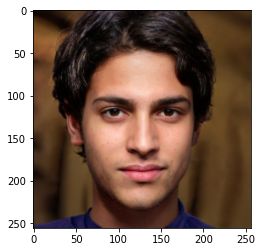

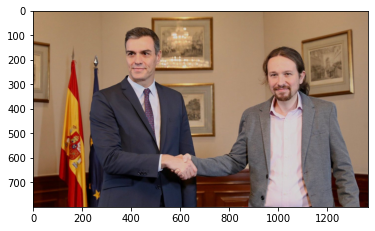

In [10]:
plt.figure()
plt.imshow(source_image)
plt.show()

plt.figure()
plt.imshow(target_image)
plt.show()

## Paso 2 - Detectar caras y ordenar por similaridad

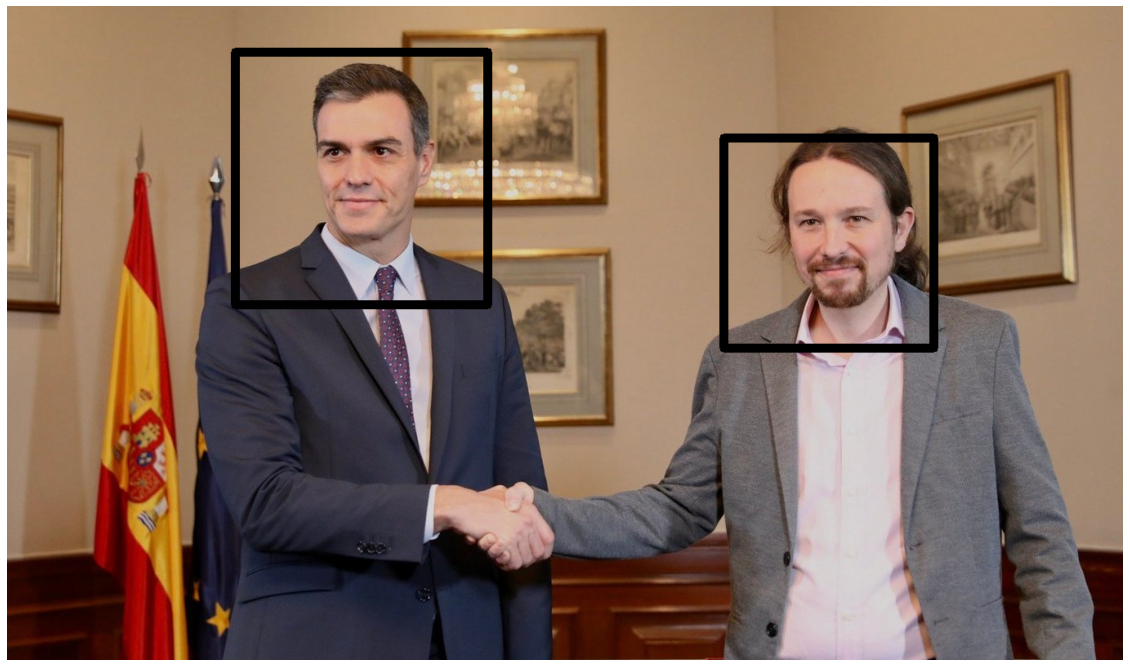

In [30]:
# Find faces in target
target_img_cv2 = cv2.cvtColor(cv2.imread(target_path), cv2.COLOR_BGR2RGB)
face_locations = face_recognition.face_locations(target_img_cv2, model="hog")

fixed_faces = []
# Draw rectangle around the faces
#for (y, w, h, x) in face_locations:
for (y_0, x_1, y_1, x_0) in face_locations:
    height = abs(y_0 - y_1) 
    width = abs(x_0 - x_1)
    
    x_0 -= width//2
    y_0 -= height//2
    
    x_1 += width//2
    y_1 += height//2
    
    fixed_faces += [[y_0,x_1,y_1,x_0]]
    
    cv2.rectangle(target_img_cv2, (x_0, y_0), (x_1, y_1), (0, 0, 0), 10)
    
# Display the output
plt.figure(figsize=(20,30))
plt.axis('off')
plt.imshow(target_img_cv2)
plt.show()

In [12]:
# Get encoding of source img
source_image_rgb = cv2.cvtColor(cv2.imread(source_path), cv2.COLOR_BGR2RGB)
source_encoding = face_recognition.face_encodings(source_image_rgb, model='ccn')[0]

# Get the encoding of each face and compare with the source
target_img_cv2 = cv2.cvtColor(cv2.imread(target_path), cv2.COLOR_BGR2RGB)
target_encodings = face_recognition.face_encodings(target_img_cv2, fixed_faces, model="cnn")

face_distances = face_recognition.face_distance(target_encodings, source_encoding)

In [13]:
faces = [[sim, pos] for sim, pos in zip(face_distances, fixed_faces)]
faces.sort(key=lambda x: x[0], reverse=True)
faces

[[0.7824260859689133, [56, 588, 365, 279]],
 [0.763835453676541, [161, 1134, 418, 877]]]

[[56, 588, 365, 279], [161, 1134, 418, 877]]
[0.78242609 0.76383545]
Similarity = 0.7824260859689133


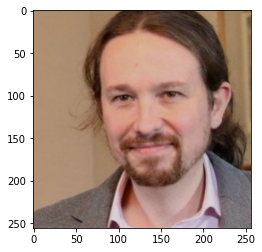

In [18]:
# Select most similar face
best_face_location = None
best_similarity = 0
print(fixed_faces)
print(face_distances)
for i, dist in enumerate(face_distances):
    if dist > best_similarity:
        best_similarity = dist
        best_face_location = fixed_faces[i]
        
        
best_face_location = fixed_faces[1]

if best_face_location:
    print(f"Similarity = {best_similarity}")
    
    y_0, x_1, y_1, x_0 = best_face_location

    crop_img = target_img_cv2[y_0:y_1,x_0:x_1]
    crop_img = resize(crop_img, (256, 256))[..., :3]
    
    w = abs(x_1-x_0)
    h = abs(y_1-y_0)

    plt.figure()
    plt.imshow(crop_img)
    plt.show()
else:
    print("No good face found")

In [21]:
a = 1

## Paso 3 - Segmentar caras con el modelo de Motion Co-Seg

In [19]:
reconstruction_module, segmentation_module = load_checkpoints(config='config/vox-256-sem-10segments.yaml', 
                                               checkpoint='../models/vox-10segments.pth.tar',
                                               blend_scale=1,
                                               cpu=True)

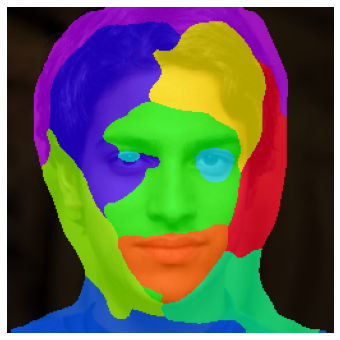

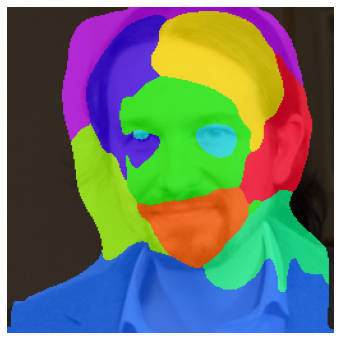

In [25]:
def visualize_segmentation(image, network, supervised=False, hard=True, colormap='gist_rainbow'):
    with torch.no_grad():
        inp = torch.tensor(image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)#.cuda()
        if supervised:
            inp = F.interpolate(inp, size=(512, 512))
            inp = (inp - network.mean) / network.std
            mask = torch.softmax(network(inp)[0], dim=1)
            mask = F.interpolate(mask, size=image.shape[:2])
        else:
            mask = network(inp)['segmentation']
            mask = F.interpolate(mask, size=image.shape[:2], mode='bilinear')
    
    if hard:
        mask = (torch.max(mask, dim=1, keepdim=True)[0] == mask).float()
    
    colormap = plt.get_cmap(colormap)
    num_segments = mask.shape[1]
    mask = mask.squeeze(0).permute(1, 2, 0).cpu().numpy()
    color_mask = 0
    patches = []
    for i in range(num_segments):
        if i != 0:
            color = np.array(colormap((i - 1) / (num_segments - 1)))[:3]
        else:
            color = np.array((0, 0, 0))
        patches.append(mpatches.Patch(color=color, label=str(i)))
        color_mask += mask[..., i:(i+1)] * color.reshape(1, 1, 3)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))

    #ax[0].imshow(color_mask)
    ax[1].imshow(0.3 * image + 0.7 * color_mask)
    #ax[1].legend(handles=patches)
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

visualize_segmentation(source_image, segmentation_module, hard=True)

visualize_segmentation(crop_img, segmentation_module, hard=True)

## Paso 4 - Intercambiar Caras

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


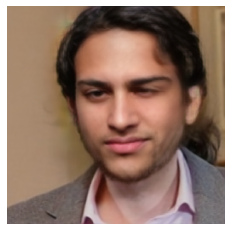

In [31]:
parts_to_swap = [1,2,3,4,5,7,9,10]

predictions = face_swap(swap_index=parts_to_swap, source_image = source_image, target_image = crop_img,
                             segmentation_module=segmentation_module, reconstruction_module=reconstruction_module, cpu=True)

plt.axis('off')
plt.imshow(predictions)
plt.show()

## Paso 5 - Devolver a la imagen original

(309, 309, 3)


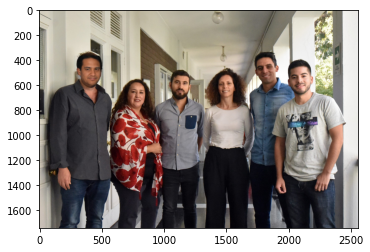

In [31]:
result_image = imageio.imread(target_path)
result_image = resize(result_image, result_image.shape[:2])[..., :3]
mask_image = resize(predictions, (h, w))[..., :3]

print(mask_image.shape)

result_image[y_0:y_1, x_0:x_1] = mask_image

plt.imshow(result_image)
plt.show()

## Step 6 - Save image

In [131]:
filename = "result" + ''.join([choice(digits) for _ in range(4)])

imageio.imwrite(f'../results/{filename}.jpg', result_image)

print(f"Saved to {f'../results/{filename}.jpg'}")

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Saved to ../results/result6712.jpg
